# 0 - Modules

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt

from os.path import exists
from os import makedirs

from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable

import unicodedata

import seaborn as sns


---

# 1 - Data Lecture

In our main dataset (birthPlaceRegion_sex), the 'Birth_Place_Region' column cointains the following nationalities:

<div style="display: flex; gap: 15px; flex-wrap: wrap;">
<div style="flex: 1; min-width: 200px;">

**Africa**
- Eastern Africa
- Middle Africa
- Northern Africa
- Southern Africa
- Western Africa

**America**
- Caribbean
- Central America
- Northern America
- South America

</div>
<div style="flex: 1; min-width: 200px;">

**Asia**
- Central Asia
- Eastern Asia
- Southern Asia
- South-Eastern Asia
- Western Asia

**Europe**
- Eastern Europe
- Northern Europe
- Southern Europe
- Western Europe

</div>
<div style="flex: 1; min-width: 200px;">

**Oceania**
- Australia and New Zealand
- Melanesia

**Others**
- Not available

</div>
</div>

Nevertheless, my team have decided to group them in the following way:

<div style="display: flex; gap: 20px; flex-wrap: wrap; justify-content: space-between;">
<div style="flex: 1; min-width: 250px;">

**Africa**
- Eastern Africa → Africa
- Middle Africa → Africa  
- Southern Africa → Africa
- Western Africa → Africa

**MENA**
- Northern Africa → MENA
- Western Asia → MENA

**Latin America**
- Caribbean → Latin America
- Central America → Latin America
- South America → Latin America

</div>
<div style="flex: 1; min-width: 250px;">

**Europe**
- Eastern Europe → Europe
- Northern Europe → Europe
- Southern Europe → Europe
- Western Europe → Europe

**NA-AUS-NZ**
- Australia and New Zealand → NA-AUS-NZ
- Northern America → NA-AUS-NZ
- Melanesia → NA-AUS-NZ

</div>
<div style="flex: 1; min-width: 250px;">

**Asia**
- Eastern Asia → Asia
- South-Eastern Asia → Asia
- Southern Asia → Asia

</div>
</div>

Finally, it is very important to notice that the Spanish population is included in the 'Europe' group. However, since we are studying immigration, it is better to separate them from the rest of European, letting them to have their own category. We will be able to do that thanks to other dataset (birthPlace_spain_v_outside) in which the groups are the following:

<div style="display: flex; gap: 20px; flex-wrap: wrap; justify-content: space-between;">
<div style="flex: 1; min-width: 250px;">

**Spain**
- City of Barcelona → Spain
- Rest of Catalonia → Spain  
- Rest of Spain → Spain

</div>
<div style="flex: 1; min-width: 250px;">

**Immigrant**
- Rest of European Union → Immigrant
- Rest of World → Immigrant

</div>
</div>

Thus, we can distinguish between Spanish population and immigrants. Consequently, we will we able to subtract the Spanish population from the 'Europe' group in the first dataset and built its own category.

## 1.1 - Lecture including Spain as a separate category

In [50]:
def lecture_df(year, add_spain, level = 'Neighborhood'): # it returns a DataFrame with the number of people per grouped region

    # ------------------------------------------------------------------------------------------------

    # --- LOAD DATA --- (Birth Place DataFrame)

    data_dir = '../data/birthPlaceRegion/'
    file = f'{year}_birthPlaceRegion_sex.csv'
    df = pd.read_csv(data_dir + file)

    # --- CLEANING ---
    
    df['Value'] = pd.to_numeric(df['Value'], errors = 'coerce').fillna(0).astype(int) # convert to numeric, coerce errors to NaN, fill NaN with 0, convert to int
    df['Birth_Place_Region'] = df['Birth_Place_Region'].astype(str).str.strip() # ensure Birth_Place_Region is string and strip whitespace 

    #  --- IGNORE SEX ---

    df = df.groupby([level, 'Birth_Place_Region'], as_index = False)['Value'].sum()

    # --- GROUPING REGIONS ---

    region_map = {
        'Eastern Africa': 'Africa',
        'Middle Africa': 'Africa',
        'Southern Africa': 'Africa',
        'Western Africa': 'Africa',

        'Caribbean': 'Latin America',
        'Central America': 'Latin America',
        'South America': 'Latin America',

        'Northern Africa': 'MENA',
        'Western Asia': 'MENA',

        'Eastern Europe': 'Europe',
        'Northern Europe': 'Europe',
        'Southern Europe': 'Europe',
        'Western Europe': 'Europe',

        'Australia and New Zealand': 'NA-AUS-NZ',
        'Northern America': 'NA-AUS-NZ',
        'Melanesia': 'NA-AUS-NZ',

        'Eastern Asia': 'Asia',
        'South-Eastern Asia': 'Asia',

        'Southern Asia': 'Asia',    
    }

    df['Group'] = df['Birth_Place_Region'].map(region_map).fillna('Other') # map regions to groups, fill unmapped with 'Other'

    # ------------------------------------------------------------------------------------------------

    # --- LOAD DATA --- (Spanish vs Immigrant DataFrame)

    data_dir2 = '../data/birthPlace_spain_v_outside/'
    file2 = f'{year}_birthPlace_spain_v_outside.csv'
    df2 = pd.read_csv(data_dir2 + file2)

    # --- CLEANING ---

    df2['Value'] = pd.to_numeric(df2['Value'], errors = 'coerce').fillna(0).astype(int) # convert to numeric, coerce errors to NaN, fill NaN with 0, convert to int
    df2['Birth_Place'] = df2['Birth_Place'].astype(str).str.strip() # ensure Birth_Place is string, strip whitespace

    # --- IGNORE SEX ---

    df2 = df2.groupby([level, 'Birth_Place'], as_index = False)['Value'].sum()

    # --- GROUPING REGIONS ---

    spanish_map = {
        'City of Barcelona': 'Spain',
        'Rest of Catalonia': 'Spain',
        'Rest of Spain': 'Spain',

        'Rest of European Union': 'Immigrant',
        'Rest of World': 'Immigrant',
    }

    df2['Group'] = df2['Birth_Place'].map(spanish_map).fillna('Other') # map birth places to groups, fill unmapped with 'Other'

    # ------------------------------------------------------------------------------------------------

    # --- SUBTRACT SPANISH FROM ORIGINAL DATAFRAME  --- (particularly, European Group)

    ## Total Spanish population per neighborhood

    spanish_df = df2[df2['Group'] == 'Spain'].groupby(level)['Value'].sum().reset_index() # get total Spanish counts per neighborhood
    spanish_df.rename(columns = {'Value': 'Spain_Value'}, inplace = True) # rename for clarity and ease to subtract

    ## Merge Spanish counts into df

    df = df.merge(spanish_df, on = level, how = 'left') 
    df['Spain_Value'] = df['Spain_Value'].fillna(0) # fill NaN with 0 

    # Subtract Spanish from Europe group

    mask_europe = df['Group'] == 'Europe' 
    df.loc[mask_europe, 'Value'] = df.loc[mask_europe, 'Value'] - df.loc[mask_europe, 'Spain_Value'] 

    # Avoid negative values due to imperfect grouping

    df['Value'] = df['Value'].clip(lower = 0) # just in case

    # --- ADD SPAIN AS A GROUP --- (CONDITIONAL)

    if add_spain:  
        spain_group = spanish_df.copy()
        spain_group['Group'] = 'Spain'
        spain_group.rename(columns={'Spain_Value': 'Value'}, inplace=True)

        df = pd.concat([df[[level, 'Group', 'Value']], 
                        spain_group[[level, 'Group', 'Value']]], 
                        ignore_index=True)

    # ------------------------------------------------------------------------------------------------
    
    absolute_groups = df.groupby([level, 'Group'], as_index = False)['Value'].sum() # final grouping

    return absolute_groups


def dictionary_df(year, add_spain, level = 'Neighborhood'): # same as above but in dictionary format with year as input

    # --- LOAD AND GROUP DATA ---

    df = lecture_df(year, add_spain, level = level)
    
    # --- CLEANING ---

    df[level] = df[level].astype(str).str.strip() # ensure level column is string and strip whitespace
    df['Group'] = df['Group'].astype(str).str.strip() # ensure Group column is string and strip whitespace
    df['Value'] = pd.to_numeric(df['Value'], errors = 'coerce').fillna(0).astype(int) # convert Value to numeric, coerce errors to NaN, fill NaN with 0, convert to int

    # --- CREATE DICTIONARY ---

    neighborhood_dict = {}
    for neighborhood in df[level].unique():
        sub_df = df[df[level] == neighborhood].drop(columns = [level])
        neighborhood_dict[neighborhood] = sub_df.reset_index(drop = True)

    return neighborhood_dict


In [51]:
# # Test

# year = 2022
# add_spain = True

# data = dictionary_df(year, add_spain)
# display(data)

---

# 2 - Diversity Calculation

## 2.1 - QUESTION: What is the diversity of each neighborhood in Barcelona?

## 2.2 -PROCEDURE:

### 2.2.1 - Simpson's Diversity Index (D) and Dataframe Creation

We are going to use the Simpsons Diversity Index to calculate the diversity of nationalities in EACH NEIGHBORHOOD, which is defined as:

$$ D = 1 - \sum_{i=1}^{S} \left( \frac{n_i}{N} \right)^2 $$

Where:

- $ D $ is the diversity index
- $ S $ is the total number of different nationalities
- $ n_i $ is the number of individuals of nationality $ i $
- $ N $ is the total number of individuals

Thus, we are taking an ecological approach to measure diversity since this index is widely used in ecology to quantify biodiversity in a community.

In [52]:
# Simpson's Diversity Index Calculation

def simpsons_diversity_index(df): # it returns the simpsons diversity index given a dataframe

    N = df['Value'].sum()

    if N == 0:
        return 0  # avoid division by zero (just in case but not expected to happen)
    
    sum_pi_squared = sum((count / N) ** 2 for count in df['Value'])
    D = 1 - sum_pi_squared

    return D


Now, we need a function that, giving a year, read the correponding data and calculate the diversity index for each neighborhood.

In [53]:
def compute_neighborhood_diversity(lecture_function, add_spain, year): # it returns a dataframe with the diversity index per neighborhood given a year

    # --- LOAD DATA ---

    df_neighborhood = lecture_function(year, add_spain)  # returns dict: neighborhood -> DataFrame
    
    # --- COMPUTE SIMPSON'S DIVERSITY INDEX ---

    diversity_results = {} # initialize empty dictionary to store results

    for label_neighborhood, df in df_neighborhood.items(): # it  works over all the neighborhoods separately (different dataframes)
        diversity_index = simpsons_diversity_index(df)
        diversity_results[label_neighborhood] = diversity_index
    
    # --- CONVERT TO DATAFRAME ---

    diversity_df = pd.DataFrame(
        list(diversity_results.items()), 
        columns=['Neighborhood', 'Simpsons_Diversity_Index']
    )
    
    # --- SORT DESCENDING --- (to better visualize the most and least diverse neighborhoods)

    diversity_df = diversity_df.sort_values(
        by = 'Simpsons_Diversity_Index', 
        ascending = False
    ).reset_index(drop = True)
    
    return diversity_df


In [54]:
# # Test

# lecture_function = dictionary_df
# add_spain = True
# year = 2022

# data = compute_neighborhood_diversity(lecture_function, add_spain, year)
# display(data)

### 2.2.2 - Visualization (color map)

In [55]:

def prepare_gdf(lecture_function, add_spain, year): # it returns a geodataframe with the diversity index per neighborhood given a year

    # --- LOAD DATA ---

    df = compute_neighborhood_diversity(lecture_function, add_spain, year)  # columns: Neighborhood, Simpsons_Diversity_Index
    # ----------------------------------------------------------------------------------------------------------------------

    # --- GEOMETRY LOADING ---
    
    geometry_file = '../data/geometry/neighborhoods_geometry.csv'
    geometry_df = pd.read_csv(geometry_file)

    # --- CONVERT WKT STRINGS TO GEOMETRIES ---

    geometry_df['Geometry_etrs89'] = geometry_df['Geometry_etrs89'].apply(wkt.loads)

    # --- CLEANING ---
    geometry_df['Neighborhood'] = geometry_df['Neighborhood'].astype(str).str.strip() # ensure Neighborhood is string and strip whitespace
    geometry_df['Neighborhood'] = geometry_df['Neighborhood'].apply(lambda x: unicodedata.normalize('NFC', x)) # normalize unicode

    # --- CREATE GEODATAFRAME ---
    gdf = gpd.GeoDataFrame(
        geometry_df,
        geometry='Geometry_etrs89',
        crs='EPSG:25831'
    )

    # ----------------------------------------------------------------------------------------------------------------------

    # --- MERGE DATAFRAMES ---
    
    merged_gdf = gdf.merge(df, on='Neighborhood', how='left')
    
    # --- CLEANING ---

    merged_gdf['Simpsons_Diversity_Index'] = merged_gdf['Simpsons_Diversity_Index'].fillna(0) # fill missing diversity values with 0

    return merged_gdf


def plot_simpsons_index(lecture_function, add_spain, year, ax): # it plots the diversity index per neighborhood given a year
    global vmin, vmax

    gdf = prepare_gdf(lecture_function, add_spain, year)

    # --- NORMALIZATION ---

    norm = Normalize(vmin = vmin, vmax = vmax)

    #  --- PLOTTING ---

    gdf.plot(column = 'Simpsons_Diversity_Index',
             ax = ax,
             cmap = 'cividis',
             norm = norm,
             linewidth = 0.4,
             edgecolor = 'black')

    ax.axis('off')

    # --- CREATE COLORBAR ---

    sm = ScalarMappable(cmap = 'cividis', norm = norm) # creates scalar mappable for colorbar
    sm.set_array([])  

    return sm 


In [56]:
# # Test

# lecture_function = dictionary_df
# add_spain = True
# year = 2022

# df_merged = prepare_gdf(lecture_function, add_spain, year)
# display(df_merged)

## 2.3 - RESULTS

Our intention will be to create a plot with two maps side by side: one showing the diversity including Spain as a separate category and another one not inluding Spain at all. Thus, in the first map, we will study the general diversity of Barcelona neighborhoods, while in the second one, we will focus on the diversity of immigrants only.

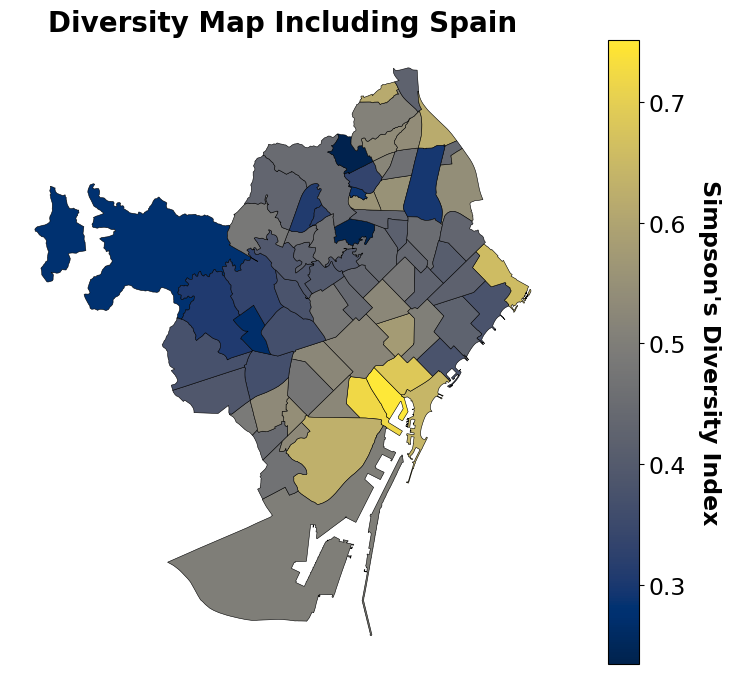

In [57]:
# CSV selection and loading

year = 2025
lecture_function = dictionary_df

# GeoDataFrames

df_merged_spain = prepare_gdf(lecture_function, True, year)
df_merged_no_spain = prepare_gdf(lecture_function, False, year)

# Global vmin and vmax for normalization

vmin = min(df_merged_spain['Simpsons_Diversity_Index'].min(), df_merged_no_spain['Simpsons_Diversity_Index'].min())
vmax = max(df_merged_spain['Simpsons_Diversity_Index'].max(), df_merged_no_spain['Simpsons_Diversity_Index'].max())

# Plotting

fig, ax1 = plt.subplots(1, 1, figsize = (14, 7))
sm1 = plot_simpsons_index(lecture_function, True, year, ax1)
# sm2 = plot_simpsons_index(lecture_function, False, year, ax2)
ax1.set_title('Diversity Map Including Spain', fontsize = 20, weight = 'bold')
# ax2.set_title('Excluding Spain', fontsize = 14, weight = 'bold')
cbar1 = fig.colorbar(sm1, ax = ax1, fraction = 0.036, pad = 0.04)
cbar1.set_label('Simpson\'s Diversity Index', fontsize = 17, weight = 'bold', labelpad = 25, rotation = 270)
cbar1.ax.tick_params(labelsize = 17)
# cbar2 = fig.colorbar(sm2, ax = ax2, fraction = 0.036, pad = 0.04)
# cbar2.set_label('Simpson\'s Diversity Index', fontsize = 12, weight = 'bold')
# plt.suptitle(f'Year = {year}', fontsize = 16, weight = 'bold')
plt.tight_layout()
plt.show()


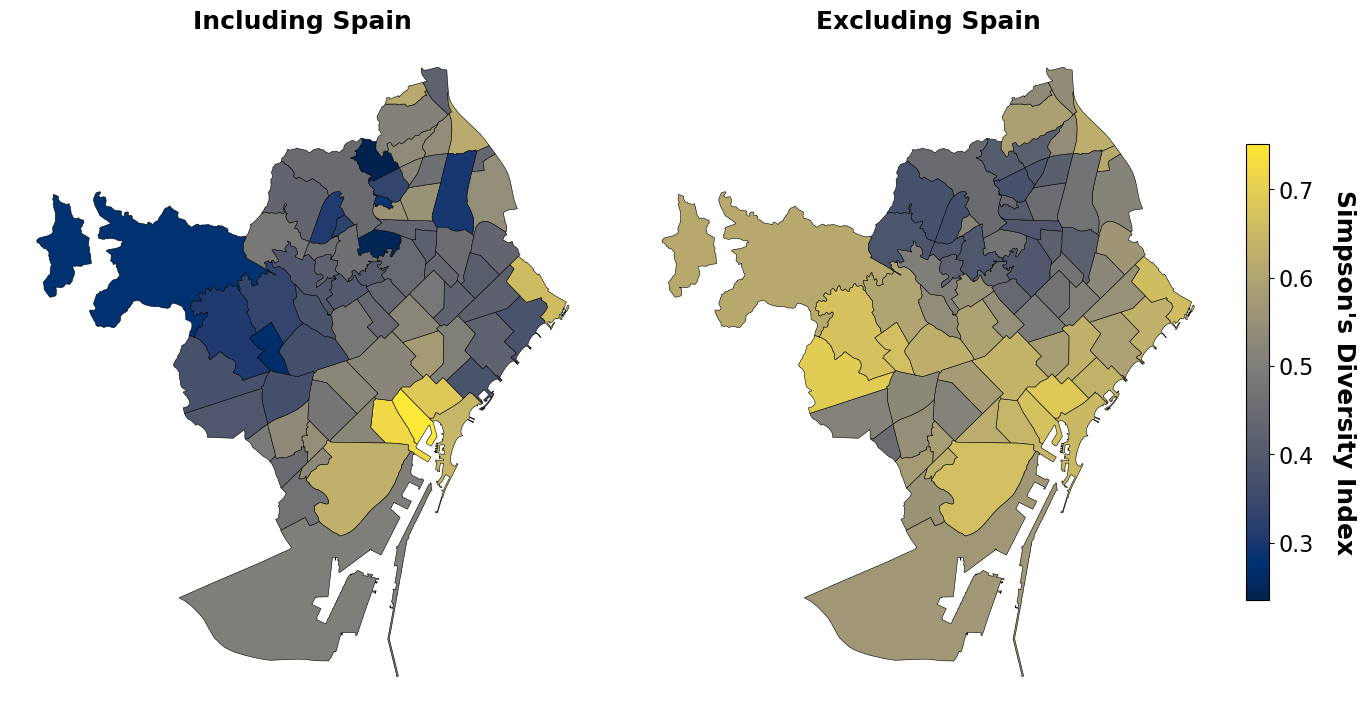

In [58]:
# CSV selection and loading

year = 2025
lecture_function = dictionary_df

# GeoDataFrames

df_merged_spain = prepare_gdf(lecture_function, True, year)
df_merged_no_spain = prepare_gdf(lecture_function, False, year)

# Global vmin and vmax for normalization

vmin = min(df_merged_spain['Simpsons_Diversity_Index'].min(), df_merged_no_spain['Simpsons_Diversity_Index'].min())
vmax = max(df_merged_spain['Simpsons_Diversity_Index'].max(), df_merged_no_spain['Simpsons_Diversity_Index'].max())

# Plotting

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 7))
sm1 = plot_simpsons_index(lecture_function, True, year, ax1)
sm2 = plot_simpsons_index(lecture_function, False, year, ax2)
ax1.set_title('Including Spain', fontsize = 18, weight = 'bold')
ax2.set_title('Excluding Spain', fontsize = 18, weight = 'bold')
# cbar1 = fig.colorbar(sm1, ax = ax1, fraction = 0.036, pad = 0.04)
# cbar1.set_label('Simpson\'s Diversity Index', fontsize = 12, weight = 'bold')
cbar2 = fig.colorbar(sm2, ax = ax2, fraction = 0.036, pad = 0.04)
cbar2.set_label('Simpson\'s Diversity Index', fontsize = 18, weight = 'bold', labelpad = 30, rotation = 270)
cbar2.ax.tick_params(labelsize = 16)

# plt.suptitle(f'Year = {year}', fontsize = 16, weight = 'bold')

plt.subplots_adjust(right=0.5) 

plt.tight_layout()
plt.show()


## 2.4 - CONCLUSIONS

We can see that, when we include Spain as a separate category, the diversity index is generally lower across neighborhoods since Spanish population represents a significant portion of the total population in many neighborhoods. Particularly, the diversity index in neighborhoods of the ritch zone (like Sarrià-Sant Gervasi or Les Corts) [Neighborhoods: Vallvidrera, Pedralbes, Sarrià] is completely different in each case, since they are mainly habited by Spanish people. Therefore, when we compute the Simpson's Diversity Index, the few nationalities present in these neighborhoods give us a high diversity value.

## 2.5 - EXTRA: time evolution of diversity in neighborhoods between 1997 and 2025

In [59]:
def df_difference(lecture_function, add_spain,initial_year, final_year): # it returns a geodataframe with the difference in diversity index between two years

    # --- LOAD INITIAL AND FINAL DATA ---

    df_initial = prepare_gdf(lecture_function, add_spain, initial_year)[['Neighborhood', 'Simpsons_Diversity_Index']]
    df_final = prepare_gdf(lecture_function, add_spain, final_year)[['Neighborhood', 'Simpsons_Diversity_Index']]

    # --- COMPUTE DIFFERENCE --- (in Simpson's Diversity Index)

    df_diff = df_final.copy()
    df_diff['Diversity_difference'] = (df_final['Simpsons_Diversity_Index'] - df_initial['Simpsons_Diversity_Index'])  
    df_diff['Diversity_difference'] = df_diff['Diversity_difference'].fillna(0)  # fill NaN values resulting from division by zero with 0
    df_diff = df_diff[['Neighborhood', 'Diversity_difference']]

    # ----------------------------------------------------------------------------------------------------------------------

    # --- GEOMETRY LOADING ---

    geometry_file = '../data/geometry/neighborhoods_geometry.csv'
    geometry_df = pd.read_csv(geometry_file)

    # --- CONVERT WKT STRINGS TO GEOMETRIES ---

    geometry_df['Geometry_etrs89'] = geometry_df['Geometry_etrs89'].apply(wkt.loads)

    # --- CLEANING ---

    geometry_df['Neighborhood'] = geometry_df['Neighborhood'].str.strip() # ensure Neighborhood is string and strip whitespace
    geometry_df['Neighborhood'] = geometry_df['Neighborhood'].apply(lambda x: unicodedata.normalize('NFC', x)) # normalize unicode

    # --- CREATE GEODATAFRAME ---

    gdf = gpd.GeoDataFrame(
        geometry_df,
        geometry='Geometry_etrs89',
        crs='EPSG:25831'
    )

    # ----------------------------------------------------------------------------------------------------------------------

    # --- MERGE DATAFRAMES ---

    gdf_diff = pd.merge(gdf, df_diff, on = 'Neighborhood', how = 'left')

    return gdf_diff


def plot_difference(lecture_function, add_spain,ax, initial_year, final_year, cmap='coolwarm'):
    global diff_vmax, diff_vmin

    # --- LOAD DIFFERENCE DATA ---

    gdf_diff = df_difference(lecture_function, add_spain, initial_year, final_year)

    # --- NORMALIZATION ---
    
    norm = Normalize(vmin = diff_vmin, vmax = diff_vmax)

    # --- MAP ---
    gdf_diff.plot(
        column = 'Diversity_difference',
        ax = ax,
        cmap = cmap,
        norm = norm,
        linewidth = 0.4,
        edgecolor = 'black'
    )

    ax.axis('off')
    
    # --- COLORBAR ---
    
    sm = ScalarMappable(cmap = cmap, norm = norm) # creates scalar mappable for colorbar
    sm.set_array([])

    return sm



C:\Users\MSI\AppData\Local\Temp\ipykernel_15380\1446998862.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


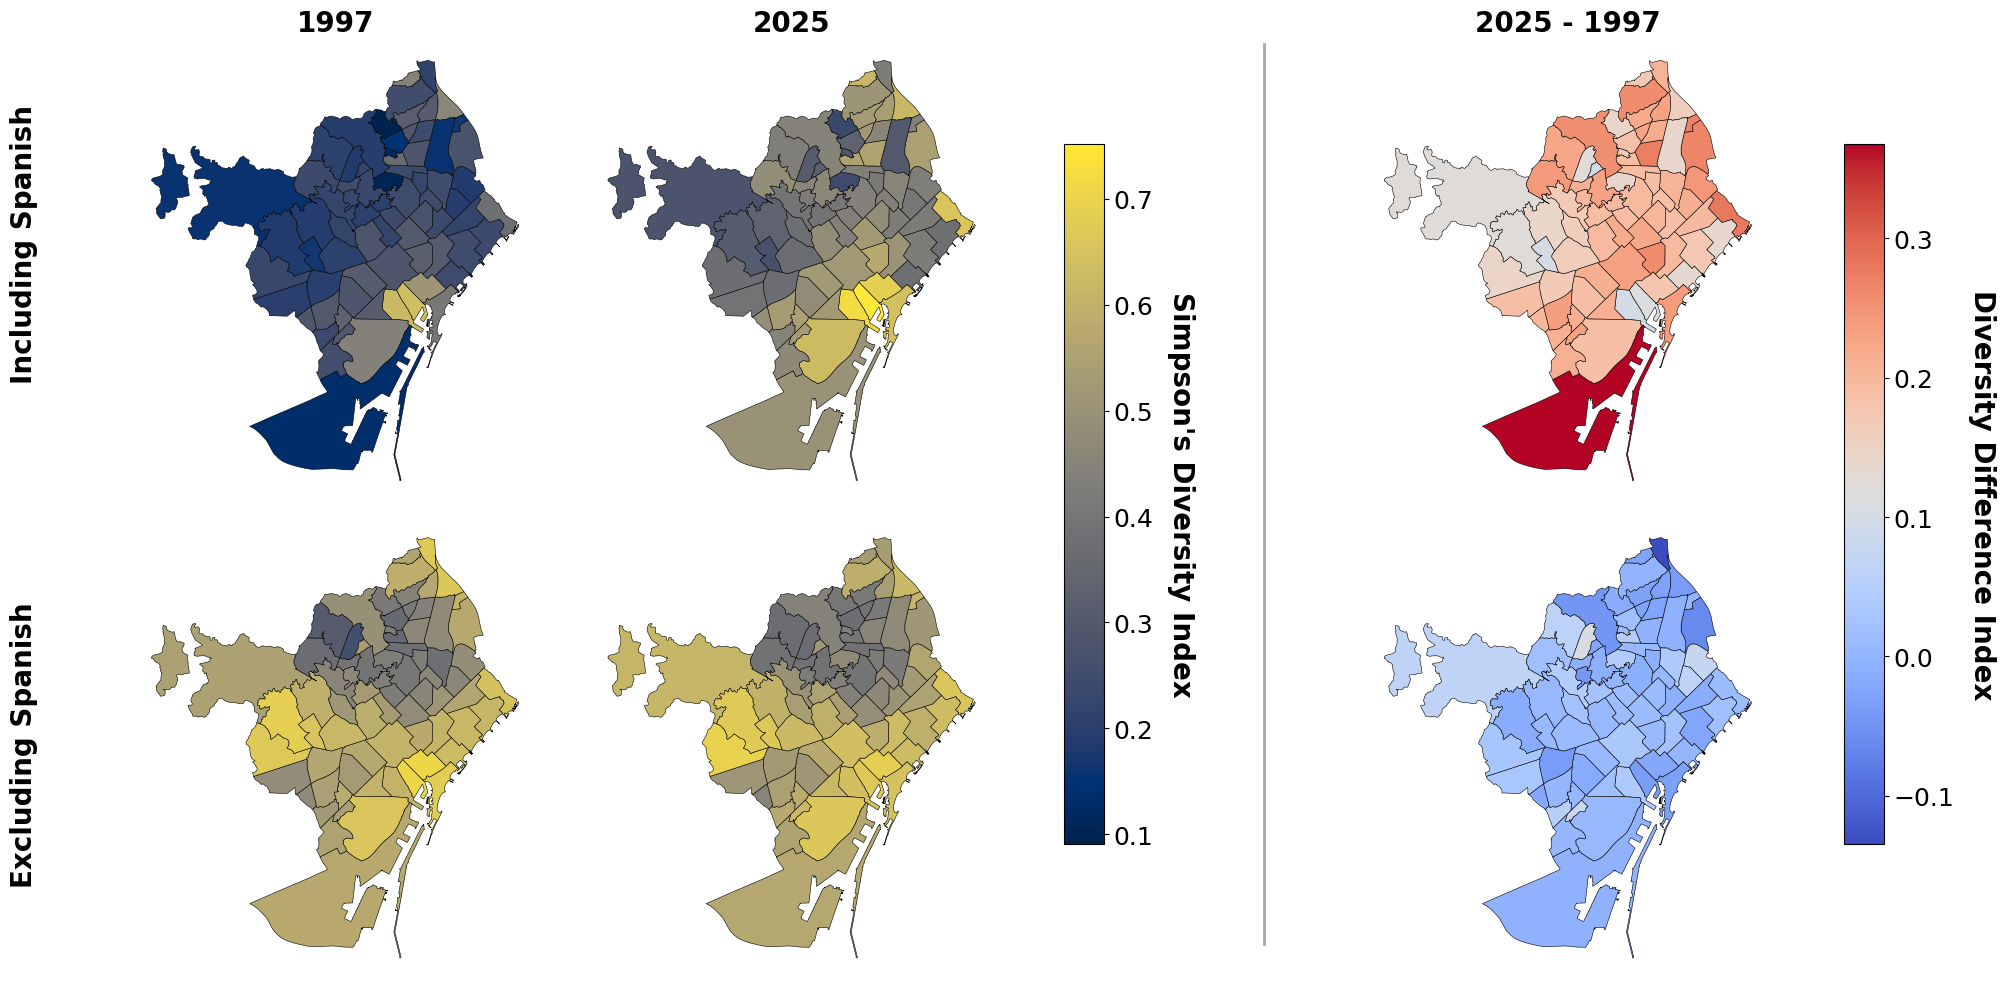

In [60]:
# CSV selection
years = [1997, 2025]

lecture_function = dictionary_df

# DataFrames
df_years_spain = {year: prepare_gdf(lecture_function, True, year) for year in years}  
df_years_no_spain = {year: prepare_gdf(lecture_function, False, year) for year in years}  

df_diff_spain = df_difference(lecture_function, True, years[0], years[1])
df_diff_no_spain = df_difference(lecture_function, False, years[0], years[1])

# Maps for each year with a common color scale
vmin_spain = min(df_years_spain[year]['Simpsons_Diversity_Index'].min() for year in years)
vmax_spain = max(df_years_spain[year]['Simpsons_Diversity_Index'].max() for year in years)

vmin_no_spain = min(df_years_no_spain[year]['Simpsons_Diversity_Index'].min() for year in years)
vmax_no_spain = max(df_years_no_spain[year]['Simpsons_Diversity_Index'].max() for year in years)

vmin = min(vmin_spain, vmin_no_spain)
vmax = max(vmax_spain, vmax_no_spain)

diff_min_spain = df_diff_spain['Diversity_difference'].min()
diff_max_spain = df_diff_spain['Diversity_difference'].max()
diff_min_no_spain = df_diff_no_spain['Diversity_difference'].min()
diff_max_no_spain = df_diff_no_spain['Diversity_difference'].max()

diff_vmin = min(diff_min_spain, diff_min_no_spain)
diff_vmax = max(diff_max_spain, diff_max_no_spain)

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
mappables = []

# --- ROW TITLES ---

fig.text(0.04, 0.75, 'Including Spanish', fontsize=20, weight='bold', ha='center', va='center', rotation=90)
fig.text(0.04, 0.25, 'Excluding Spanish', fontsize=20, weight='bold', ha='center', va='center', rotation=90)

# --- FIXED ORDERED LOOP ---
for i, year in enumerate(years):
    # Row 0: Including Spain
    sm1 = plot_simpsons_index(lecture_function, True, year, axes[0, i])
    mappables.append(sm1)
    axes[0, i].set_title(f'{year}', fontsize=20, weight='bold')
    
    # Row 1: Excluding Spain
    sm2 = plot_simpsons_index(lecture_function, False, year, axes[1, i])
    mappables.append(sm2)
    # axes[1, i].set_title(f'{year}', fontsize=20, weight='bold')

# Difference plots
sm_diff1 = plot_difference(lecture_function, True, axes[0, 2], years[0], years[1])
sm_diff2 = plot_difference(lecture_function, False, axes[1, 2], years[0], years[1])
axes[0, 2].set_title(f'{years[1]} - {years[0]}', fontsize=20, weight='bold')
# axes[1, 2].set_title(f'Difference\n({years[1]} - {years[0]})', fontsize=20, weight='bold')

# Shared colorbar for first 4 maps (positioned between columns 2-3-5-6)
cbar_ax1 = fig.add_axes([0.56, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar1 = fig.colorbar(sm1, cax=cbar_ax1)
cbar1.set_label('Simpson\'s Diversity Index', fontsize=20, weight='bold', labelpad=30, rotation=270)
cbar1.ax.tick_params(labelsize=18)

# Shared colorbar for difference maps (positioned left of columns 3-6)
cbar_ax2 = fig.add_axes([0.95, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar2 = fig.colorbar(sm_diff1, cax=cbar_ax2)
cbar2.set_label('Diversity Difference Index', fontsize=20, weight='bold', labelpad=30, rotation=270)
cbar2.ax.tick_params(labelsize=18)

plt.tight_layout()
plt.subplots_adjust(right=1)  # Make space for the colorbars

# Vertical grey divider between column 2025 (col=1) and Difference (col=2)
fig.add_artist(
    plt.Line2D(
        [0.66, 0.66],   # x-coordinates (fraction of figure width)
        [0.05, 0.95], # y-coordinates (fraction of figure height)
        color='grey',
        linewidth=2,
        alpha=0.7
    )
)

# -------------------------------------------------------
# SHIFT COLUMN 1 (the 2025 maps) SLIGHTLY LEFT
# -------------------------------------------------------
shift = -0.08   # adjust as needed (-0.02, -0.04, etc.)

for row in range(2):
    ax = axes[row, 1]      # column 1
    pos = ax.get_position()
    ax.set_position([pos.x0 + shift, pos.y0, pos.width, pos.height])

plt.show()

---

# 3 - Similarity between neighborhoods

## 3.1 - QUESTION: Giving some neighborhoods that we know are (not) diverse, how similar are them culturally taking into account the nationalities present in each neighborhood (percentage)?

## 3.2 - PROCEDURE:

We are going to use the cosine similarity method to calculate how similar the neighborhoods are, culturally speaking. That means that we have to take into account the nationality distribution in each neighborhood, not only the diversity index.

In order to do that, we will create a vector for each neighborhood, and in the overall, a matrix where:

- Rows -> Neighborhoods
- Columns -> Nationalities
- Values -> Percentage of each nationality 


In [61]:
# def nationality_proportion_matrix(lecture_function, add_spain, year, neighborhood_selection): # it returns a matrix with the nationality proportions per neighborhood

#     # --- LOAD DATA ---

#     df = lecture_function(year, add_spain)

#     ##  Keep only selected neighborhoods

#     df = df[df['Neighborhood'].isin(neighborhood_selection)]

#     # --- PIVOT TO MATRIX --- (to have neighborhoods as rows and groups as columns)

#     matrix = df.pivot(index = 'Neighborhood',
#                       columns = 'Group',
#                       values = 'Value').fillna(0)

#     # --- CONVERT TO PROPORTIONS --- (to have proportions instead of absolute counts)

#     matrix = matrix.div(matrix.sum(axis=1), axis=0)

#     return matrix

def nationality_proportion_matrix_all(lecture_function, add_spain, year): # it returns a matrix with the nationality proportions per neighborhood

    # --- LOAD DATA ---

    df = lecture_function(year, add_spain)

    # Sort neighborhoods by diversity index

    diversity_df = compute_neighborhood_diversity(dictionary_df, add_spain, year)
    sorted_neighborhoods = diversity_df['Neighborhood'].tolist()

    df['Neighborhood'] = pd.Categorical(df['Neighborhood'], categories=sorted_neighborhoods, ordered=True)

    # --- PIVOT TO MATRIX --- (to have neighborhoods as rows and groups as columns)

    matrix = df.pivot(index = 'Neighborhood',
                      columns = 'Group',
                      values = 'Value').fillna(0)

    # --- CONVERT TO PROPORTIONS --- (to have proportions instead of absolute counts)

    matrix = matrix.div(matrix.sum(axis=1), axis=0)

    return matrix

## 3.3 - RESULTS: 

In [62]:
year = 2025
lecture_function = lecture_df

### 3.3.1 - Including Spain

In [63]:
add_spain = False

Firstly, we will sort a dataframe of the neighborhoods by their diversity index, from the least diverse to the most diverse. 

In [64]:
df_diversity_spain  = compute_neighborhood_diversity(dictionary_df, add_spain, year)
sorted_neighborhoods = df_diversity_spain['Neighborhood']
display(df_diversity_spain)

,Neighborhood,Simpsons_Diversity_Index
0,Pedralbes,0.696142
1,"Sant Pere, Santa Caterina i la Ribera",0.685962
2,Sarrià,0.672281
3,el Barri Gòtic,0.670617
4,les Tres Torres,0.664041
...,...,...
68,Verdun,0.387773
69,Sant Genís dels Agudells,0.385608
70,la Guineueta,0.373180
71,Montbau,0.370962


Now, we compute the similarity matrix.

In [65]:
matrix_spain  = nationality_proportion_matrix_all(lecture_function, add_spain, year) # ordered by diversity index 

display(matrix_spain)

Group,Africa,Asia,Europe,Latin America,MENA,NA-AUS-NZ,Other
Neighborhood,,,,,,,
Pedralbes,0.016413,0.180945,0.081265,0.486389,0.146117,0.078863,0.010008
"Sant Pere, Santa Caterina i la Ribera",0.020487,0.148060,0.131928,0.503266,0.131334,0.061263,0.003662
Sarrià,0.021900,0.130906,0.124262,0.526575,0.097933,0.087598,0.010827
el Barri Gòtic,0.022555,0.475493,0.052646,0.283182,0.138419,0.025537,0.002169
les Tres Torres,0.009115,0.141059,0.086806,0.531250,0.130642,0.095486,0.005642
...,...,...,...,...,...,...,...
Verdun,0.021658,0.109323,0.017946,0.770008,0.081064,0.000000,0.000000
Sant Genís dels Agudells,0.022809,0.071629,0.036815,0.775110,0.080032,0.013605,0.000000
la Guineueta,0.017572,0.082981,0.027335,0.781972,0.085910,0.004230,0.000000


Now it is time to compute the cosine similarity matrix. Lets remember the formula:

$$ \text{cosine\_similarity}(A, B) = \frac{A \cdot B}{||A|| \cdot ||B||} $$

In [66]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute similarity matrix

cos_sim = cosine_similarity(matrix_spain.values)

# Convert to DataFrame for better readability

cos_sim_df_spain = pd.DataFrame(
    cos_sim,
    index = matrix_spain.index,
    columns = matrix_spain.index
)

display(cos_sim_df_spain)

Neighborhood,Pedralbes,"Sant Pere, Santa Caterina i la Ribera",Sarrià,el Barri Gòtic,les Tres Torres,el Poble-sec,el Besòs i el Maresme,la Barceloneta,el Raval,la Dreta de l'Eixample,...,el Turó de la Peira,el Guinardó,Vilapicina i la Torre Llobeta,la Teixonera,el Carmel,Verdun,Sant Genís dels Agudells,la Guineueta,Montbau,la Vall d'Hebron
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Pedralbes,1.000000,0.992823,0.987411,0.792392,0.994654,0.966754,0.911400,0.984366,0.768859,0.982521,...,0.950962,0.940251,0.946094,0.943462,0.944938,0.945866,0.939882,0.941184,0.943538,0.941385
"Sant Pere, Santa Caterina i la Ribera",0.992823,1.000000,0.995927,0.746462,0.994145,0.952580,0.876624,0.997209,0.722896,0.992902,...,0.954589,0.953413,0.953415,0.952608,0.953036,0.951390,0.950161,0.949651,0.952989,0.951906
Sarrià,0.987411,0.995927,1.000000,0.712869,0.995782,0.940304,0.854912,0.992434,0.690376,0.998692,...,0.962247,0.965509,0.963514,0.963464,0.963302,0.960918,0.961926,0.960199,0.962977,0.964024
el Barri Gòtic,0.792392,0.746462,0.712869,1.000000,0.729953,0.897834,0.959092,0.714533,0.998200,0.685338,...,0.639303,0.595624,0.622710,0.609803,0.616016,0.629509,0.594488,0.604626,0.613294,0.607550
les Tres Torres,0.994654,0.994145,0.995782,0.729953,1.000000,0.944127,0.870060,0.989093,0.705507,0.994839,...,0.966677,0.962808,0.964734,0.963743,0.964346,0.963200,0.961954,0.961629,0.963358,0.962842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Verdun,0.945866,0.951390,0.960918,0.629509,0.963200,0.899871,0.818490,0.959556,0.609123,0.970828,...,0.999532,0.997209,0.999745,0.999230,0.999538,1.000000,0.998379,0.999276,0.999059,0.998158
Sant Genís dels Agudells,0.939882,0.950161,0.961926,0.594488,0.961954,0.882194,0.790564,0.959817,0.572649,0.973005,...,0.997372,0.999357,0.999088,0.999698,0.999438,0.998379,1.000000,0.999715,0.999190,0.998924
la Guineueta,0.941184,0.949651,0.960199,0.604626,0.961629,0.886904,0.798961,0.959346,0.583111,0.971228,...,0.998677,0.998719,0.999629,0.999830,0.999823,0.999276,0.999715,1.000000,0.999570,0.998859


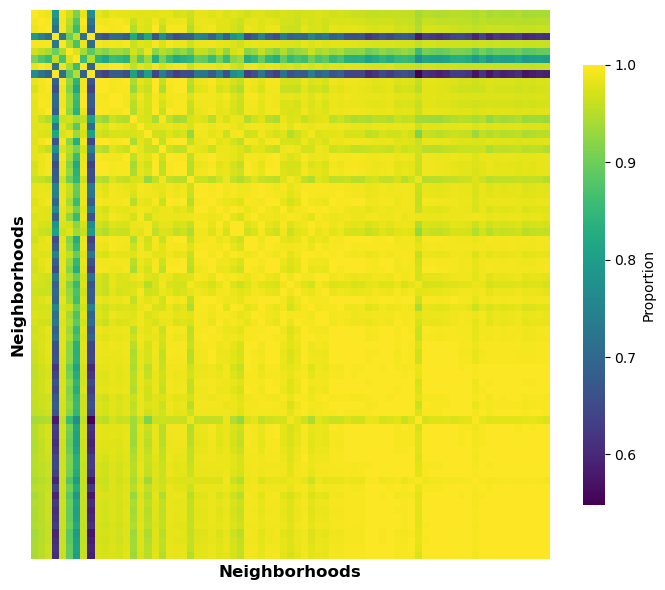

In [67]:
plt.figure(figsize=(7, 6))

# Create seaborn heatmap
sns.heatmap(cos_sim_df_spain, 
            annot=False,
            cmap='viridis',
            cbar_kws={'label': 'Proportion', 'shrink': 0.8},
            xticklabels=False,
            yticklabels=False)

plt.xlabel('Neighborhoods', fontsize=12, weight='bold')
plt.ylabel('Neighborhoods', fontsize=12, weight='bold')

plt.tight_layout()
plt.show()

---
---

# EXTRA: Rent - Diversity

In [68]:
def prepare_gdf_rent(year, level = 'Neighborhood'): # it reads the data and prepares the geodataframe with the rent per capita information for the neighborhoods of Barcelona

    # --- LOAD DATA ---

    data_dir = '../data/indicadores_socioeconomicos/'
    file = f'ist-14075-15023-mun_{year}.csv'

    df = pd.read_csv(data_dir + file, sep = ';', decimal = ',', engine = 'python')

    # --- DATA SELECTION ---

    df_filtered = df[df['concepto'] == 'renta media por persona (€)'] # filter for rent per capita
    df_selection = df_filtered[['barrios de Barcelona', 'valor']].copy() # select relevant columns

    # --- RENAME --- (in order to match with the geometry file)

    df_selection.rename(columns = {
        'barrios de Barcelona': 'Neighborhood',
        'valor': 'rent_per_capita'
    }, inplace = True)

    # --- DATA CLEANING ---

    df_selection['rent_per_capita'] = pd.to_numeric(df_selection['rent_per_capita'], errors = 'coerce').fillna(0).astype(float) # convert to numeric, set errors to NaN, fill NaN with 0, convert to float
    df_selection['Neighborhood'] = df_selection['Neighborhood'].astype(str).str.strip().str.lower() # convert to string, strip whitespace, convert to lowercase
    df_selection['Neighborhood'] = df_selection['Neighborhood'].apply(lambda x: unicodedata.normalize('NFC', x)) # normalize unicode characters

    # ------------------------------------------------------------------------------------------------------------------------------------------

    # --- RENAME ---

    df_selection['Neighborhood'] = df_selection['Neighborhood'].replace('sant gervasi-la bonanova', 'sant gervasi - la bonanova')
    df_selection['Neighborhood'] = df_selection['Neighborhood'].replace('el poble sec', 'el poble-sec')
    df_selection['Neighborhood'] = df_selection['Neighborhood'].replace('sants-badal', 'sants - badal')
    df_selection['Neighborhood'] = df_selection['Neighborhood'].replace('sant gervasi-galvany', 'sant gervasi - galvany')
    

    # ------------------------------------------------------------------------------------------------------------------------------------------

    # --- MERGE ---

    return df_selection


In [69]:
year = 2022
add_spain = True

df_diversity_spain  = compute_neighborhood_diversity(dictionary_df, add_spain, year)

# ------------------

rent_per_neighborhood_df = prepare_gdf_rent(2022)
# display(rent_per_neighborhood_df)
df_diversity_spain['Neighborhood'] = df_diversity_spain['Neighborhood'].str.lower()
# display(df_diversity_spain)

list_neighborhoods_rent = rent_per_neighborhood_df['Neighborhood'].tolist()
list_diversity_spain_rent = df_diversity_spain['Neighborhood'].tolist()

different_neighborhoods = set(list_neighborhoods_rent) - set(list_diversity_spain_rent)
print("Neighborhoods in rent data but not in diversity data:", different_neighborhoods) 
different_neighborhoods2 = set(list_diversity_spain_rent) - set(list_neighborhoods_rent)
print("Neighborhoods in diversity data but not in rent data:", different_neighborhoods2)

# print(list_neighborhoods_rent)
# print(list_diversity_spain_rent)


Neighborhoods in rent data but not in diversity data: {'total'}
Neighborhoods in diversity data but not in rent data: set()


In [70]:
# Plot of the rent vs diversity index

merged_df = rent_per_neighborhood_df.merge(
    df_diversity_spain, on='Neighborhood', how='inner'
)

display(merged_df)

,Neighborhood,rent_per_capita,Simpsons_Diversity_Index
0,el raval,10893.0,0.697407
1,el barri gòtic,13971.0,0.747325
2,la barceloneta,14117.0,0.596670
3,"sant pere, santa caterina i la ribera",15379.0,0.651806
4,el fort pienc,19279.0,0.492764
...,...,...,...
68,diagonal mar i el front marítim del poblenou,20593.0,0.337242
69,el besòs i el maresme,11577.0,0.580008
70,provençals del poblenou,16402.0,0.344936
71,sant martí de provençals,15546.0,0.331826


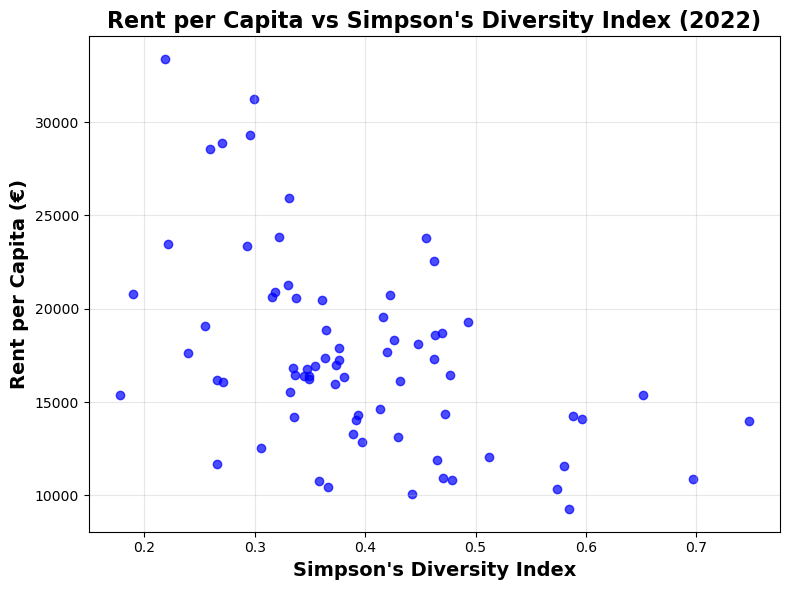

In [71]:
# Plot rent per capita vs Simpson's Diversity Index
plt.figure(figsize=(8, 6))
plt.scatter(merged_df['Simpsons_Diversity_Index'], merged_df['rent_per_capita'], color='blue', alpha=0.7)
plt.title('Rent per Capita vs Simpson\'s Diversity Index (2022)', fontsize=16, weight='bold')
plt.ylabel('Rent per Capita (€)', fontsize=14, weight='bold')
plt.xlabel('Simpson\'s Diversity Index', fontsize=14, weight='bold')    
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

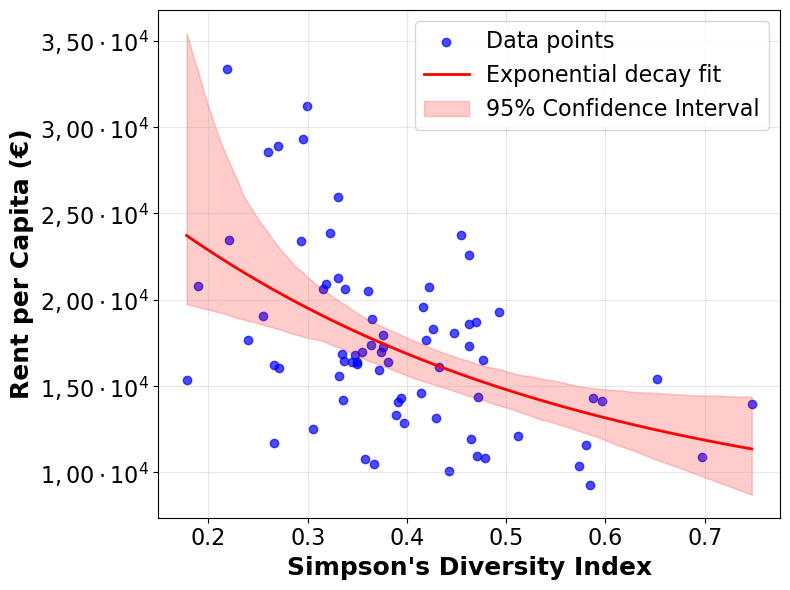

Exponential decay parameters:
a = 25447.56, b = 2.39, c = 7096.17


In [72]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# --- LATEX SCIENTIFIC NOTATION ---
def latex_sci_formatter(y, pos):
    if y == 0:
        return r"$0$"
    exponent = int(np.floor(np.log10(abs(y))))
    coeff = y / (10**exponent)
    coeff_str = f"{coeff:.2f}".replace('.', ',')  # decimal comma
    return rf"${coeff_str} \cdot 10^{{{exponent}}}$"

# --- FIT MODEL ---
def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

# --- LOAD DATA ---
x = merged_df['Simpsons_Diversity_Index']
y = merged_df['rent_per_capita']

# --- FIT ---
initial_guess = [max(y), 1, min(y)]
params, covariance = curve_fit(exp_decay, x, y, p0=initial_guess, maxfev=5000)

x_smooth = np.linspace(x.min(), x.max(), 100)
y_smooth = exp_decay(x_smooth, *params)

# --- CONFIDENCE INTERVAL ---
n_bootstraps = 500
bootstrap_preds = []

for _ in range(n_bootstraps):
    indices = np.random.choice(len(x), len(x), replace=True)
    x_boot = x.iloc[indices]
    y_boot = y.iloc[indices]
    
    params_boot, _ = curve_fit(exp_decay, x_boot, y_boot, p0=params, maxfev=5000)
    y_boot_pred = exp_decay(x_smooth, *params_boot)
    bootstrap_preds.append(y_boot_pred)

bootstrap_preds = np.array(bootstrap_preds)
lower_ci = np.percentile(bootstrap_preds, 2.5, axis=0)
upper_ci = np.percentile(bootstrap_preds, 97.5, axis=0)

# --- PLOT ---
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='blue', alpha=0.7, label='Data points')
plt.plot(x_smooth, y_smooth, color='red', linewidth=2, label='Exponential decay fit')
plt.fill_between(x_smooth, lower_ci, upper_ci, color='red', alpha=0.2, label='95% Confidence Interval')

plt.ylabel('Rent per Capita (€)', fontsize=18, weight='bold')
plt.xlabel("Simpson's Diversity Index", fontsize=18, weight='bold')

# --- APPLY LATEX SCIENTIFIC NOTATION TO Y-AXIS ---
plt.gca().yaxis.set_major_formatter(FuncFormatter(latex_sci_formatter))

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()

# --- PRINTS  ---
print("Exponential decay parameters:")
print(f"a = {params[0]:.2f}, b = {params[1]:.2f}, c = {params[2]:.2f}")
